# BEST:
# BEST METHOD KEEP THIS:

In [196]:
import numpy as np
import sympy as sp
from typing import List, Tuple, Dict, Any, Set
from scipy.stats import levy
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

class all_parameter_generation:
    """
    Generate state transitions and random parameters (a, b, c, enzyme) for an n-site phosphorylation model.

    Args:
        n: number of sites (int)
        distribution: distribution name ("gamma" supported)
        params: parameters for the distribution (for gamma: [shape, scale])
        verbose: if True, prints transitions and matrices
    """
    def __init__(self, n: int, reaction_types: str, distribution: str, distribution_paramaters: List[float], verbose: bool = False):
        self.n = n
        # self.num_states = n**2
        self.num_states = n + 1
        self.distribution = distribution
        self.params = distribution_paramaters
        self.reaction_types = reaction_types
        self.verbose = verbose
        self.rng = np.random.default_rng()
        
    @staticmethod
    def padded_binary(i: int, n: int) -> str:
        return bin(i)[2:].zfill(n)

    @staticmethod
    def binary_string_to_array(string: str) -> np.ndarray:
        return np.array([int(i) for i in string], dtype=int)

    def calculate_valid_transitions(self) -> Tuple[List[List[Any]], List[List[Any]]]:
        """
        Returns:
            valid_X_reactions: list of [state_i_str, state_j_str, i, j, "E"]
            valid_Y_reactions: list of [state_i_str, state_j_str, i, j, "F"]
        """
        all_states = [self.padded_binary(i, self.n) for i in range(self.num_states)]

        valid_difference_vectors: Set[Tuple[int, ...]] = set()
        valid_X_reactions: List[List[Any]] = []
        valid_Y_reactions: List[List[Any]] = []

        for i in range(self.num_states):
            arr_i = self.binary_string_to_array(all_states[i])
            for j in range(self.num_states):
                if i == j:
                    continue
                arr_j = self.binary_string_to_array(all_states[j])
                diff = arr_j - arr_i
                # if self.reaction_types == "distributive":
                    
                hamming_weight = np.sum(np.abs(diff))

                if hamming_weight == 1:
                    # +1 -> phosphorylation (E), -1 -> dephosphorylation (F)
                    element = "E" if np.any(diff == 1) else "F"
                    if element == "E":
                        if self.verbose:
                            print(f"{all_states[i]} --> {all_states[j]} (E), {i}, {j}")
                        valid_X_reactions.append([all_states[i], all_states[j], i, j, element])
                    else:
                        if self.verbose:
                            print(f"{all_states[i]} --> {all_states[j]} (F), {i}, {j}")
                        valid_Y_reactions.append([all_states[i], all_states[j], i, j, element])
                    valid_difference_vectors.add(tuple(diff))

        return valid_X_reactions, valid_Y_reactions
    
    def alpha_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray,
                                            Dict[int, List[int]], Dict[int, List[int]],
                                            Dict[int, List[int]], Dict[int, List[int]]]:
        
        # valid_X_reactions, valid_Y_reactions = self.calculate_valid_transitions()

        shape, scale = self.params

        # alpha_matrix = np.zeros((self.num_states, self.num_states))
        alpha_array = np.array([self.rng.gamma(shape, scale) for i in range(self.n)])
        alpha_matrix = np.diag(alpha_array, 1)
        
        # alpha_matrix = np.diag([self.rng.gamma(shape, scale)]*(min(self.num_states, self.num_states - 1)), 1)[:self.num_states, :self.num_states]
        # for _, _, i, j, _ in valid_X_reactions:

        #     alpha_matrix[i][j] = self.rng.gamma(shape, scale)

        return alpha_matrix


    def beta_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray,
                                            Dict[int, List[int]], Dict[int, List[int]],
                                            Dict[int, List[int]], Dict[int, List[int]]]:
        
        # valid_X_reactions, valid_Y_reactions = self.calculate_valid_transitions()

        shape, scale = self.params
        beta_array = np.array([self.rng.gamma(shape, scale) for i in range(self.n)])
        
        beta_matrix = np.diag(beta_array, -1)
        # beta_matrix = np.zeros((self.num_states, self.num_states))
        
        # for _, _, i, j, _ in valid_Y_reactions:

        #     beta_matrix[i][j] = self.rng.gamma(shape, scale)

        # beta_matrix = np.diag([self.rng.gamma(shape, scale)]*(min(self.num_states-1, self.num_states)), -1)[:self.num_states, :self.num_states]
        
        return beta_matrix
    
    def k_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray]:
        # if self.distribution != "gamma":
        #     raise NotImplementedError("Only 'gamma' distribution implemented for a_parameter_generation")
        shape, scale = self.params
        if self.distribution == "gamma":
            k_positive_rates = self.rng.gamma(shape, scale, self.num_states - 1)
            k_negative_rates = self.rng.gamma(shape, scale, self.num_states - 1)
        if self.distribution == "levy":
            k_positive_rates = levy.rvs(loc=shape, scale=scale, size=self.num_states - 1, random_state=self.rng)
            k_negative_rates = levy.rvs(loc=shape, scale=scale, size=self.num_states - 1, random_state=self.rng)
        
        # k_positive_rates = np.ones(self.num_states - 1)
        # k_negative_rates = np.ones(self.num_states - 1)

        return k_positive_rates, k_negative_rates

    def p_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray]:
        
        # if self.distribution != "gamma":
        #     raise NotImplementedError("Only 'gamma' distribution implemented for b_parameter_generation")
        shape, scale = self.params
        if self.distribution == "gamma":
            p_positive_rates = self.rng.gamma(shape, scale, self.num_states - 1)
            p_negative_rates = self.rng.gamma(shape, scale, self.num_states - 1)
        if self.distribution == "levy":
            p_positive_rates = levy.rvs(loc=shape, scale=scale, size=self.num_states - 1, random_state=self.rng)
            p_negative_rates = levy.rvs(loc=shape, scale=scale, size=self.num_states - 1, random_state=self.rng)

        # p_positive_rates = np.ones(self.num_states - 1)
        # p_negative_rates = np.ones(self.num_states - 1)

        return p_positive_rates, p_negative_rates
    
    def total_concentration_generation(self) -> Tuple[np.ndarray, np.ndarray]:
        
        # if self.distribution != "gamma":
        #     raise NotImplementedError("Only 'gamma' distribution implemented for b_parameter_generation")
        shape, scale = self.params
        if self.distribution == "gamma":
            x_tot_concentration = self.rng.gamma(shape, scale, 1)
            y_tot_concentration = self.rng.gamma(shape, scale, 1)

        return x_tot_concentration, y_tot_concentration

In [ ]:
def MATTIA_FULL(t, state_array, n, Kp, Pp, G, H, Q, M_mat, D, N_mat):

    N = n + 1
    ones_vec = np.ones(N - 1)
    
    # assert len(state_array) == 3*N
    # print(state_array)
    a = state_array[0: N]
    b = state_array[N: 2*N - 1]
    c = state_array[2*N - 1: 3*N - 2]
    x = float(state_array[-2])
    y = float(state_array[-1])

    a_dot = (G @ b) + (H @ c) - x * (Kp @ a) - y * (Pp @ a)  
    b_dot = x * (Q @ a) - (M_mat @ b)
    c_dot = y * (D @ a) - (N_mat @ c)

    x_dot = -1*ones_vec.T @ b_dot
    y_dot = -1*ones_vec.T @ c_dot

    return np.concatenate((a_dot, b_dot, c_dot, np.array([x_dot, y_dot])))

# def jacobian_reduced(t, state_array, n, x_tot, y_tot, L1, L2, W1, W2):
#     N = 2**n
#     ones_vec_j = np.ones(N - 1)
#     # a_fixed_points = np.array(a_fixed_points).reshape((N, 1))  # shape (N, 1)
#     a = state_array[0: N].astype(float)

#     # L1 = np.array(L1, dtype=float)
#     # L2 = np.array(L2, dtype=float)
#     # W1 = np.array(W1, dtype=float)
#     # W2 = np.array(W2, dtype=float)

#     # Compute denominators
#     denom1 = 1 + float(ones_vec_j @ (W1 @ a))
#     denom2 = 1 + float(ones_vec_j @ (W2 @ a))

#     # Compute terms
#     term1 = (L1 / denom1) - np.outer(L1 @ a, ones_vec_j @ W1) / (denom1**2)
#     term2 = (L2 / denom2) - np.outer(L2 @ a, ones_vec_j @ W2) / (denom2**2)
#     return (x_tot / y_tot) * term1 + term2

def MATTIA_REDUCED(t, state_array, n, x_tot, y_tot, L1, L2, W1, W2):

    N = n + 1
    ones_vec = np.ones(N - 1)

    assert len(state_array) == N

    a = state_array[0: N].astype(float)

    ###### PSEUDO-STEADY STATE APPROXIMATION IS MADE HERE, BUT ODE IS NOT DIMENSIONLESS
    a_dot = ((x_tot * L1 @ a) / (1 + ones_vec @ W1 @ a)) + (y_tot * (L2 @ a) / (1 + ones_vec @ W2 @ a)) 

    return a_dot

def MATRIX_FINDER(n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates):

    N = n + 1
    ones_vec = np.ones(N - 1)

    Kp = np.diag(np.append(k_positive_rates, 0))
    Km = np.append(np.diag(k_negative_rates), np.zeros((1, len(k_negative_rates))), axis=0)

    Pp = np.diag(np.insert(p_positive_rates, 0, 0))
    Pm = np.vstack([np.zeros((1, len(p_negative_rates))), np.diag(p_negative_rates)])    # print("a", a)

    adjusted_alpha_mat = np.delete(alpha_matrix, -1, axis = 0)
    adjusted_beta_mat = np.delete(beta_matrix, 0, axis = 0)

    Da = np.diag(alpha_matrix[:-1, 1:] @ ones_vec)
    Db = np.diag(beta_matrix[1:, :-1] @ ones_vec)

    U = np.diag(k_negative_rates)
    I = np.diag(p_negative_rates)
    Q = Kp[:-1, :]
    D = np.delete(Pp, 0, axis=0)

    M_mat = U + Da
    N_mat = I + Db

    G = Km + adjusted_alpha_mat.T
    H = Pm + adjusted_beta_mat.T

    M_inv = np.linalg.inv(M_mat); N_inv = np.linalg.inv(N_mat)

    L1 = G @ M_inv @ Q - Kp; L2 = H @ N_inv @ D - Pp
    W1 = M_inv @ Q; W2 = N_inv @ D

    return Kp, Pp, G, H, Q, M_mat, D, N_mat, L1, L2, W1, W2

def phosphorylation_system_solver(parameters_tuple, initial_states_array, final_t, full_model):

    n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates, a_tot, x_tot, y_tot = parameters_tuple
    N = n + 1

    assert np.all(initial_states_array <= (a_tot + 1e-12))
    assert np.all(initial_states_array >= 0)
    assert np.all(initial_states_array <= a_tot)

    #### SCALING TIME
    initial_t = 0
    # final_t = 2000
    t_span = (initial_t, final_t)

    ###### OBTAINING ALL MATRICES
    Kp, Pp, G, H, Q, M_mat, D, N_mat, L1, L2, W1, W2 = MATRIX_FINDER(n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates)
    cmap = plt.get_cmap('tab10')
    def color_for_species(idx):
        return cmap(idx % cmap.N)
    
    plt.figure(figsize = (8, 6))
    plt.style.use('seaborn-v0_8-whitegrid')

    abstol = 1e-20
    reltol = 1e-5
    
    if full_model == False:
        assert len(initial_states_array) == N

        mattia_reduced_parameter_tuple = (n, x_tot, y_tot, L1, L2, W1, W2)
        # t_array = np.linspace(t_span[0], t_span[1], 500)
        sol = solve_ivp(MATTIA_REDUCED, t_span = t_span, y0=np.asarray(initial_states_array, dtype=float), 
                        args = mattia_reduced_parameter_tuple, method = 'LSODA', atol = abstol, rtol = reltol)
        # jac = jacobian_reduced
        a_solution_stack = np.stack([sol.y[i] for i in range(0, N)]) / a_tot

        for i in range(a_solution_stack.shape[0]):
            color = color_for_species(i)
            plt.plot(sol.t, a_solution_stack[i], color=color, label = f"[$A_{i}]$", lw=4, alpha = 0.4)
            print(f"final A_{i} = {a_solution_stack[i][-1]}")
            plt.title(f"Plotting reduced phosphorylation dynamics for n = {n}")

    if full_model == True:
        assert len(initial_states_array) == 3*n + 3
        # assert np.all(initial_states_array >= 1e-15)
        assert np.all(initial_states_array >= 0)

        mattia_parameter_tuple = (n, Kp, Pp, G, H, Q, M_mat, D, N_mat)
        # t_array = np.linspace(t_span[0], t_span[1], 500)
        sol = solve_ivp(MATTIA_FULL, t_span = t_span, y0=np.asarray(initial_states_array, dtype=float), 
                        args = mattia_parameter_tuple, method = 'LSODA', atol = abstol, rtol = reltol)

        a_solution_stack = np.stack([sol.y[i] for i in range(0, N)]) / a_tot
        # b_solution_stack = np.stack([sol.y[i] for i in range(N, 2*N - 1)]) 
        # c_solution_stack = np.stack([sol.y[i] for i in range(2*N - 1, 3*N - 2)]) 
        # x_solution = sol.y[-2]
        # y_solution = sol.y[-1]
        # for i in range(b_solution_stack.shape[0]):
        #     color = color_for_species(i + a_solution_stack.shape[0])
        #     plt.plot(sol.t, b_solution_stack[i], color=color, label = f"$B_{i}$", lw=1.5, linestyle='-', alpha = 0.75)
        #     print(f"final B_{i} = {b_solution_stack[i][-1]}")

        # for i in range(c_solution_stack.shape[0]):
        #     color = color_for_species(i + a_solution_stack.shape[0] + b_solution_stack.shape[0] - 1)
        #     plt.plot(sol.t, c_solution_stack[i], color=color, label=f"$C_{i+1}$", lw=1, linestyle='--', alpha = 1)
        #     print(f"final C_{i+1} = {c_solution_stack[i][-1]}")

        # print(f"final X = {x_solution[-1]}")
        # print(f"final Y = {y_solution[-1]}")
        # print(a_solution_stack)

        for i in range(a_solution_stack.shape[0]):
            color = color_for_species(i)
            plt.plot(sol.t, a_solution_stack[i], color=color, label = f"$[A_{i}]$", lw=4, alpha = 0.4)
            print(f"final numerical fp of A_{i}: {a_solution_stack[i][-1]}")
            plt.title(f"full system dynamics for n = {n}")
        # plt.plot(sol.t, x_solution, color='black', label="$X$", lw=1.75, alpha = 0.75)
        # plt.plot(sol.t, y_solution, color='gray', label="$Y$", lw=1, alpha = 0.75)
    # plt.figure(figsize = (8, 6))
    plt.ylabel("concentration")
    plt.xlabel("time")
    plt.minorticks_on()
    plt.tight_layout()
    plt.xlim(t_span[0] - 0.1, t_span[1] + 0.1)
    plt.ylim(-0.05, 1.1)
    plt.legend(frameon=False)
    plt.show()
    
    # from mpl_toolkits.mplot3d import Axes3D  # registers the 3D projection
    # fig = plt.figure(figsize = (8, 6))
    # ax = fig.add_subplot(111, projection='3d')
    # ax.plot(a_solution_stack[0], a_solution_stack[2], a_solution_stack[3], color='blue', linewidth=2)
    # plt.show()
    # plt.figure(figsize = (8, 6))
    # plt.style.use('seaborn-v0_8-whitegrid')
    # plt.scatter(a_solution_stack[0][0], a_solution_stack[3][0], c = 'r', label = "IC")
    # plt.plot(a_solution_stack[0], a_solution_stack[3], 'k', lw=4, alpha = 0.4)
    # plt.xlabel("$A_0$")
    # plt.ylabel("$A_1$")
    # plt.title(f"phase portrait of full system dynamics for n = {n}")
    # plt.minorticks_on()
    # plt.xlim(-0.05, 1.1)
    # plt.ylim(-0.05, 1.1)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()
        # plt.title(f"Plotting full phosphorylation dynamics for n = {n}")
        # # plt.plot(sol.t, x_solution, color='black', label="$X$", lw=1.75, alpha = 0.75)
        # # plt.plot(sol.t, y_solution, color='gray', label="$Y$", lw=1, alpha = 0.75)
        # plt.ylabel("concentration")
        # plt.xlabel("time (s)")
        # plt.minorticks_on()
        # plt.tight_layout()
        # plt.xlim(t_span[0] - 1, t_span[1] + 1)
        # plt.ylim()
        # plt.legend(frameon=False)
        # plt.show()

    # WRITE CODE THAT EXPORTS DATA AS FILE


530
[[0.02798305 0.58403955 0.3879774 ]]
# of stable states is 1
# of unstable states is 1
stable state 0: [0.02798305 0.58403955 0.3879774 ]
unstable state 0: [0.02798305 0.58403955 0.3879774 ]
final A_0 = 0.02798305086993772
final A_1 = 0.5840395516849582
final A_2 = 0.38797739744543575


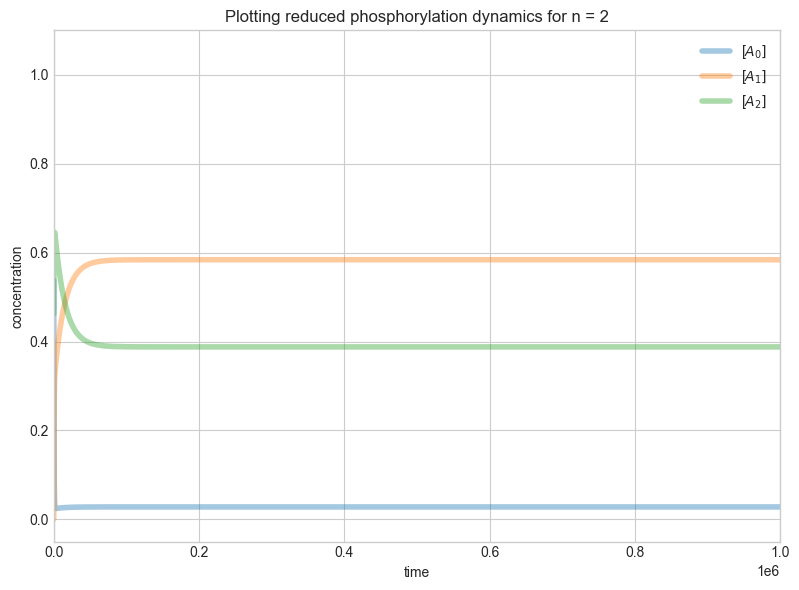

In [519]:
import numpy as np
import pickle
import random

def plotter(full_model_bool, index, final_t, file_name):
    n = int(file_name[-5:-4])
    N = n + 1

    if file_name[0:14] == 'multistability':
        with open(file_name, "rb") as f:
            multistable_results = pickle.load(f)
        print(len(multistable_results))
        a_stable_states = multistable_results[index]["stable_states"]
        print(a_stable_states)
        a_unstable_states = multistable_results[index]["unstable_states"]
        num_stable_states = multistable_results[index]["num_of_stable_states"]
        num_unstable_states = multistable_results[index]["num_of_unstable_states"]
        a_tot_parameter = multistable_results[index]["total_concentration_values"][0]
        x_tot_parameter = multistable_results[index]["total_concentration_values"][1]
        y_tot_parameter = multistable_results[index]["total_concentration_values"][2]
        alpha_matrix = multistable_results[index]["alpha_matrix"]; alpha_matrix = alpha_matrix / np.mean(alpha_matrix)
        beta_matrix = multistable_results[index]["beta_matrix"]; beta_matrix = beta_matrix / np.mean(beta_matrix)
        k_positive_rates = multistable_results[index]["k_positive"]
        k_negative_rates = multistable_results[index]["k_negative"]
        p_positive_rates = multistable_results[index]["p_positive"]
        p_negative_rates = multistable_results[index]["p_negative"]
        print(f"# of stable states is {num_stable_states}")
        print(f"# of unstable states is {num_unstable_states}")
        # a_stable_states = np.ravel(a_stable_states)*a_tot_parameter
        for i, fp in enumerate(a_stable_states):
            print(f"stable state {i}: {fp}")
        for i, fp in enumerate(a_unstable_states):
            print(f"unstable state {i}: {fp}")

        rate_min, rate_max = 1e-1, 1e7
        def matrix_clip(matrix):
            clipped = matrix.copy()
            mask = clipped != 0
            clipped[mask] = np.clip(clipped[mask], rate_min, rate_max)
            return clipped
        
        # clipping
        alpha_matrix = matrix_clip(alpha_matrix); beta_matrix = matrix_clip(beta_matrix)
        a_init_conditions_reduced = a_stable_states[np.random.randint(0, num_stable_states)]

        a_init_conditions_full = a_init_conditions_reduced

        # print("a_init_conditions_full:", a_init_conditions_full)
        def pertubation_array_creation(ic_array, pertubation_parameter):
            # find the 2 indices with the largest elements, create a pertubation array
            largest_index = np.argsort(ic_array)[-2:][-2]
            second_largest_index = np.argsort(ic_array)[-2:][-1]
            return np.array([-pertubation_parameter if i == largest_index else pertubation_parameter if i == second_largest_index else 0 for i in range(len(ic_array))])
            
        pertubation_parameter = 0.01

        Kp, Pp, G, H, Q, M_mat, D, N_mat, L1, L2, W1, W2 = MATRIX_FINDER(n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates)

        if full_model_bool == False:
            pertubation_array = pertubation_array_creation(a_init_conditions_reduced, pertubation_parameter)
            # print(pertubation_array)
            # initial_states_array_reduced_perturbed = a_init_conditions_reduced + pertubation_array

            # print(f"The initial condition is: {initial_states_array_reduced}")
            alpha = np.random.rand()
            initial_states_array_reduced = np.concatenate([np.array([alpha]), np.zeros(1), np.array([1-alpha])])
            parameters_tuple = (n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates, a_tot_parameter, x_tot_parameter, y_tot_parameter)
            phosphorylation_system_solver(parameters_tuple, initial_states_array_reduced, final_t, full_model_bool)

        if full_model_bool == True:

            ones_vec = np.ones((1, N-1), dtype = float)

            # # a_init_conditions = a_stable_states
            x_init_condition = x_tot_parameter / float(1.0 + np.dot(ones_vec, (W1 @ a_init_conditions_full)))
            y_init_condition = y_tot_parameter / float(1.0 + np.dot(ones_vec, (W2 @ a_init_conditions_full)))

            b_init_conditions = x_init_condition * (W1 @ a_init_conditions_full)
            c_init_conditions = y_init_condition * (W2 @ a_init_conditions_full)
            print(b_init_conditions)
            print(c_init_conditions)
            # if random.random() < 0.5:
            #     pertubation_array[0] = -pertubation_parameter; pertubation_array[2] = pertubation_parameter
            # else:
            #     pertubation_array[0] = pertubation_parameter; pertubation_array[2] = -pertubation_parameter

            # print(len(initial_states_array_full_random))
            # pertubation_array = np.zeros(3*N); 
            if random.random() < 0.5:
                pertubation_array = pertubation_array_creation(a_init_conditions_full, pertubation_parameter, True)
            else:
                pertubation_array = pertubation_array_creation(a_init_conditions_full, pertubation_parameter, False)
            initial_states_array_full = np.concatenate([np.ravel(a_init_conditions_full + pertubation_array), np.ravel(b_init_conditions), np.ravel(c_init_conditions), np.ravel(x_init_condition), np.ravel(y_init_condition)]).astype(float)
            print(len(initial_states_array_full))
            parameters_tuple = (n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates, a_tot_parameter, x_tot_parameter, y_tot_parameter)
            phosphorylation_system_solver(parameters_tuple, initial_states_array_full, final_t, full_model_bool)

# file_name = "multistability_parameters_5000_2.pkl"
file_name = "multistability_parameters_5000_2.pkl"

index = 2
# subindex = 0
full_model_bool = False
final_t = 1000000
plotter(full_model_bool, index, final_t, file_name)

In [368]:
def jacobian_reduced_root(state_array, n, x_tot, y_tot, L1, L2, W1, W2):

    # N = state_array.size + 1
    # N = state_array.size**2
    N = n + 1
    a_red = np.asarray(state_array, dtype=float)
    assert a_red.size == N - 1, f"expected b of length {N-1}, got {a_red.size}"

    a_fixed_points = np.concatenate([a_red, [1-np.sum(a_red)]])
    # a_fixed_red = np.asarray(state_array, dtype = float)

    ones_vec_j = np.ones((1, N-1), dtype = float) # shape (1, N-1)

    a_fixed_points = a_fixed_points.reshape((N, 1))  # shape (N, 1)
    L1 = np.array(L1, dtype=float)
    L2 = np.array(L2, dtype=float)
    W1 = np.array(W1, dtype=float)
    W2 = np.array(W2, dtype=float)

    # Compute denominators
    denom1 = float(1 + np.dot(ones_vec_j, (W1 @ a_fixed_points)).item())
    denom2 = float(1 + np.dot(ones_vec_j, (W2 @ a_fixed_points)).item())

    term1 = (L1 / denom1) - (((L1 @ a_fixed_points) @ (ones_vec_j @ W1)) / (denom1**2))
    term2 = (L2 / denom2) - (((L2 @ a_fixed_points) @ (ones_vec_j @ W2)) / (denom2**2))

    p = x_tot / y_tot

    J = (p * term1) + term2
    return J[:N-1, :N-1]

def MATTIA_REDUCED_ROOT(state_array, n, x_tot, y_tot, L1, L2, W1, W2):

    N = n + 1
    # N = n**2
    ones_vec = np.ones(N - 1)
    a_red = np.asarray(state_array, dtype = float)
    assert a_red.size == N - 1, f"expected b of length {N-1}, got {a_red.size}"

    # assert len(state_array) == N

    a = np.concatenate([a_red, [1 - np.sum(a_red)]])

    a_dot = (((x_tot/y_tot) * L1 @ a) / (1 + ones_vec @ W1 @ a)) + ((L2 @ a) / (1 + ones_vec @ W2 @ a)) 
    # a_dot = ((x_tot * L1 @ a) / (1 + ones_vec @ W1 @ a)) + ((y_tot * L2 @ a) / (1 + ones_vec @ W2 @ a)) 

    return a_dot[: N-1]

def jac_MATTIA_reparam(b, n, x_tot, y_tot, L1, L2, W1, W2):
    """
    Analytic Jacobian: returns matrix shape (N-1, N-1)
    J_ij = d/d b_j [ MATTIA_reparam(b)[i] ].
    """
    N = n + 1
    b = np.asarray(b, dtype=float)
    assert b.size == N - 1, f"expected b of length {N-1}, got {b.size}"
    # build full a
    last = 1.0 - np.sum(b)
    a = np.concatenate([b, [last]])

    ones_reduced = np.ones(N - 1)

    # intermediate quantities
    u1 = L1 @ a             # shape (N,)
    u2 = L2 @ a
    v1 = W1 @ a             # shape (N-1,)
    v2 = W2 @ a
    d1 = 1.0 + ones_reduced @ v1   # scalar
    d2 = 1.0 + ones_reduced @ v2   # scalar

    # A_db: N x (N-1) mapping db -> da
    # top (N-1) rows = identity, last row = -1
    A_db = np.vstack([np.eye(N - 1), -np.ones((1, N - 1))])   # shape (N, N-1)

    # du_db: (N, N-1) = L @ A_db
    du1_db = L1 @ A_db
    du2_db = L2 @ A_db

    # dd_db: (N-1,) where dd_db[j] = ones_reduced @ (W @ A_db[:, j])
    # compute W @ A_db -> shape (N-1, N-1), then ones_reduced @ that -> (N-1,)
    W1A = W1 @ A_db     # (N-1, N-1)
    W2A = W2 @ A_db
    dd1_db = ones_reduced @ W1A   # shape (N-1,)
    dd2_db = ones_reduced @ W2A

    # Now build J: for each j column, compute column vector of length N (then take only first N-1 rows)
    # vectorised formula:
    # part1[:, j] = x_tot * ( du1_db[:, j]*d1 - u1 * dd1_db[j] ) / d1**2
    # part2 similar with y_tot
    # We only need rows 0..N-2
    # Broadcast shapes: du1_db[:N-1, :] is (N-1, N-1); u1[:N-1,None] is (N-1,1); dd1_db[None,:] is (1,N-1)
    term1 = x_tot * (du1_db[:N-1, :] * d1 - (u1[:N-1, None] * dd1_db[None, :])) / (d1 ** 2)
    term2 = y_tot * (du2_db[:N-1, :] * d2 - (u2[:N-1, None] * dd2_db[None, :])) / (d2 ** 2)

    J = term1 + term2   # shape (N-1, N-1)
    return J

def stability_calculator(a_fixed_points, p, L1, L2, W1, W2):

    a_fixed_points = np.asarray(a_fixed_points, dtype=float).ravel()
    N = a_fixed_points.size

    ones_vec_j = np.ones((1, N-1), dtype = float) # shape (1, N-1)

    a_fixed_points = a_fixed_points.reshape((N, 1))  # shape (N, 1)
    L1 = np.array(L1, dtype=float)
    L2 = np.array(L2, dtype=float)
    W1 = np.array(W1, dtype=float)
    W2 = np.array(W2, dtype=float)

    # Compute denominators
    denom1 = float(1 + np.dot(ones_vec_j, (W1 @ a_fixed_points)).item())
    denom2 = float(1 + np.dot(ones_vec_j, (W2 @ a_fixed_points)).item())

    term1 = (L1 / denom1) - (((L1 @ a_fixed_points) @ (ones_vec_j @ W1)) / (denom1**2))
    term2 = (L2 / denom2) - (((L2 @ a_fixed_points) @ (ones_vec_j @ W2)) / (denom2**2))

    J = (p * term1) + term2
    return J

In [420]:
import numpy as np
from scipy.optimize import root
from numpy import linalg as LA

sites_n = 2
N = sites_n + 1
# example: sites_n = 2  => N = 3  => b length 2
b0 = 0.1*np.ones(N-1)   # initial guess for the free variables

# assuming you already computed:
gen_rates = all_parameter_generation(sites_n, "distributive", "gamma", (0.123, 4.46e6), verbose = False)
rate_min, rate_max = 1e-1, 1e7
alpha_matrix = gen_rates.alpha_parameter_generation(); alpha_matrix = alpha_matrix / np.mean(alpha_matrix)
beta_matrix = gen_rates.beta_parameter_generation(); beta_matrix = beta_matrix / np.mean(beta_matrix)
k_positive_rates = np.ones(N - 1)
k_negative_rates = np.ones(N - 1)
p_positive_rates = np.ones(N - 1)
p_negative_rates = np.ones(N - 1)
# k_positive_rates = np.clip(gen_rates.k_parameter_generation()[0], rate_min, rate_max)
# k_negative_rates = np.clip(gen_rates.k_parameter_generation()[1], rate_min, rate_max)
# p_positive_rates = np.clip(gen_rates.p_parameter_generation()[0], rate_min, rate_max)
# p_negative_rates = np.clip(gen_rates.p_parameter_generation()[1], rate_min, rate_max)
concentrations_best_shape_parameters = (0.40637, 0.035587)
gen_concentrations = all_parameter_generation(sites_n, "distributive", "gamma", concentrations_best_shape_parameters, verbose = False)
concentration_min, concentration_max = 1e-4, 1e-1
x_tot_value = np.clip(gen_concentrations.total_concentration_generation()[0], concentration_min, concentration_max)
y_tot_value = np.clip(gen_concentrations.total_concentration_generation()[1], concentration_min, concentration_max)
Kp, Pp, G, H, Q, M_mat, D, N_mat, L1, L2, W1, W2 = MATRIX_FINDER(sites_n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates)
res = root(MATTIA_REDUCED_ROOT, x0=b0, jac=jacobian_reduced_root, method='hybr', args=(sites_n, x_tot_value, y_tot_value, L1, L2, W1, W2))
print("success:", res.success)
print("b solution:", res.x)
# reconstruct full a from b solution:
a_sol = np.concatenate([res.x, [1.0 - np.sum(res.x)]])
print("a (full) solution:", a_sol)
print("residual (last N-1 eqns):", res.fun)

J = stability_calculator(a_sol, x_tot_value / y_tot_value, L1, L2, W1, W2)
# if not np.all(np.isfinite(J)) or np.isnan(J).any():
# if not np.isfinite(J).all():
#     print("infinite detected")
#     continue  # skip this guess if J contains NaN or inf

eigenvalues = LA.eigvals(J)
eigenvalues_real = np.real(eigenvalues)  

eigen_value_tol = 1e-16
if np.max(eigenvalues_real) > eigen_value_tol:
    print("unstable")
elif np.all(eigenvalues_real < -eigen_value_tol):
    print("stable")


success: True
b solution: [0.12183543 0.34489714]
a (full) solution: [0.12183543 0.34489714 0.53326742]
residual (last N-1 eqns): [-4.16333634e-16  6.27276009e-15]


In [331]:
j = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
print(j[:N-1, :N-1])

[[1 2]
 [4 5]]


In [4]:
##################### constructing initial parameter vectors/matrices
# gen = all_parameter_generation(n, "distributive", "gamma", (0.5, 1), verbose = False)
# alpha_matrix = gen.alpha_parameter_generation()
# beta_matrix = gen.beta_parameter_generation()
# k_positive_rates, k_negative_rates = gen.k_parameter_generation()
# p_positive_rates, p_negative_rates = gen.p_parameter_generation()


####################
# ones_vec = np.ones(N)
# alpha_matrix = np.array([[0, 1, 1, 0],
#                         [0, 0, 0, 1],
#                         [0, 0, 0, 1],
#                         [0, 0, 0, 0]])
# beta_matrix = np.array([[0, 0, 0, 0],
#                         [1, 0, 0, 0],
#                         [1, 0, 0, 0],
#                         [0, 1, 1, 0]])
# k_positive_rates = np.array([1, 1, 1, 0])
# k_negative_rates = np.array([1, 1, 1, 0])
# p_positive_rates = np.array([0, 1, 1, 1])
# p_negative_rates = np.array([0, 1, 1, 1])
#################### constructing additional needed matrices

# k_positive_matrix = np.diag(k_positive_rates); k_negative_matrix = np.diag(k_negative_rates)
# p_positive_matrix = np.diag(p_positive_rates); p_negative_matrix = np.diag(p_negative_rates)
# diagonal_loss_alpha_matrix = np.diag(alpha_matrix @ ones_vec); diagonal_loss_beta_matrix = np.diag(beta_matrix @ ones_vec)

In [5]:


# def jacobian_full

In [6]:
# if file_name[0:13] == 'monostability':
#     with open(file_name, "rb") as f:
#         monostable_results = pickle.load(f)
#     num_stable_states = monostable_results[index]["num_of_stable_states"]
#     a_stable_states = monostable_results[index]["stable_states"]
#     a_tot_parameter = monostable_results[index]["total_concentration_values"][0]
#     x_tot_parameter = monostable_results[index]["total_concentration_values"][1]
#     y_tot_parameter = monostable_results[index]["total_concentration_values"][2]
#     alpha_matrix = monostable_results[index]["alpha_matrix"]
#     beta_matrix = monostable_results[index]["beta_matrix"]
#     k_positive_rates = monostable_results[index]["k_positive"]
#     k_negative_rates = monostable_results[index]["k_negative"]
#     p_positive_rates = monostable_results[index]["p_positive"]
#     p_negative_rates = monostable_results[index]["p_negative"]

#     a_stable_states = np.ravel(a_stable_states)*a_tot_parameter
#     a_init_conditions = a_stable_states.reshape((N, 1))

#     print(f"# of stable states is {len(a_stable_states)}")

#     if full_model_bool == True:
#         ones_vec = np.ones((1, N-1), dtype = float)
#         Kp, Pp, G, H, Q, M_mat, D, N_mat, L1, L2, W1, W2 = MATRIX_FINDER(n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates)

#         # a_init_conditions = a_stable_states
#         x_init_condition = x_tot_parameter / float(1.0 + np.dot(ones_vec, (W1 @ a_init_conditions)))
#         y_init_condition = y_tot_parameter / float(1.0 + np.dot(ones_vec, (W2 @ a_init_conditions)))

#         b_init_conditions = x_init_condition * (W1 @ a_init_conditions)
#         c_init_conditions = y_init_condition * (W2 @ a_init_conditions)
#         print("Simulating monostability in the full model:")
#         initial_states_array_full_random = np.concatenate([np.ravel(a_init_conditions), np.ravel(b_init_conditions), np.ravel(c_init_conditions), np.ravel(x_init_condition), np.ravel(y_init_condition)]).astype(float)

#         # pertubation = np.zeros(3*N); pertubation[0] = pertubation[0] - 0.1; pertubation[14] = pertubation[14] + 0.1
#         pertubation = np.zeros(3*N); pertubation[0] = pertubation[0] + 0.1; pertubation[N] = pertubation[N] - 0.1

#         initial_states_array_full_random = initial_states_array_full_random + pertubation
        

#         parameters_tuple = (n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates, a_tot_parameter, x_tot_parameter, y_tot_parameter)
#         phosphorylation_system_solver(parameters_tuple, initial_states_array_full_random, final_t, full_model_bool)
#     if full_model_bool == False:
#         print("Simulating monostability in the reduced model:")
#         initial_states_array_reduced_random = np.insert(np.zeros(N - 1), 0, a_tot_parameter)
#         # initial_states_array_reduced_random = np.random.rand(N)
#         # initial_states_array_reduced_random = initial_states_array_reduced_random / np.sum(initial_states_array_reduced_random)
#         parameters_tuple = (n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates, a_tot_parameter, x_tot_parameter, y_tot_parameter)
#         phosphorylation_system_solver(parameters_tuple, initial_states_array_reduced_random, final_t, full_model_bool)



In [7]:
file_name = 'bistability_parameters_100_4.csv'
print(n)

NameError: name 'n' is not defined

In [2411]:
import pickle